In [1]:
### %pylab inline
import pickle
import pandas as pd
import csv
import re
import time
import os
import numpy as np
import itertools
from numpy import mean
from copy import deepcopy
from matplotlib import pyplot as plt

from scipy import stats
import random
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.autograd import Variable
import random
import scipy.optimize

# to check which python is using
# import sys
# sys.executable
import statistics
%matplotlib inline

In [2]:
trajectories = pickle.load(open('./Data/trajectory_info/cgail_trajs2.pkl', 'rb'))

In [ ]:
'''state info'''
traffic = pickle.load(open('./Data/features_condition/latest_traffic.pkl', 'rb'))
volume = pickle.load(open('./Data/features_condition/latest_volume_pickups.pkl', 'rb'))
train_airport = pickle.load(open('./Data/features_condition/train_airport.pkl', 'rb'))
'''user info'''
home_locs = pickle.load(open('./Data/features_condition/home_loc_plates_dict_all.pkl','rb'))
trip_info_dict = pickle.load(open('./Data/features_condition/trip_info_dict_789.pkl', 'rb'))
start_finishing_time = pickle.load(open('./Data/features_condition/start_finishing_time.pkl', 'rb'))
ave_monthly_working_info = pickle.load(open('./Data/features_condition/ave_monthly_working_time_distance.pkl', 'rb'))
waiting_dict = pickle.load(open('./Data/features_condition/waiting_dict.pkl', 'rb'))

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x724cc5993e50>>
Traceback (most recent call last):
  File "/home/robert/FAMAIL/.conda/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [4]:
'''get all valid locations'''
valid_locations = set()
for key in traffic:
    loc = (key[0], key[1])
    valid_locations.add(loc)
print(len(valid_locations))
valid_locations = list(valid_locations)

3821


## Handle state actions

In [5]:
def judging_action(x, y, nx, ny):
    if x == 0 and y == 0:
        return 9
    if nx == 0 and ny == 0:
        return 9 # stop
    if x == nx and ny > y:
        return 0
    if x < nx and ny > y:
        return 1
    if x < nx and ny == y:
        return 2
    if x < nx and ny < y:
        return 3
    if x == nx and ny < y:
        return 4
    if x > nx and ny < y:
        return 5
    if x > nx and ny == y:
        return 6
    if x > nx and ny > y:
        return 7
    if x == nx and y == ny:
        return 8

def decide_next_state(dirc, current_state, timestep=1):
    if current_state[2] < 289:
        new_time = current_state[2] + timestep
    else:
        new_time = (current_state[2]+timestep)%288
    
    if dirc == 0:
        new_step = [current_state[0], current_state[1]+1, new_time]
        return new_step
    if dirc == 1: 
        new_step = [current_state[0]+1, current_state[1]+1, new_time] 
        return new_step
    if dirc == 2:
        new_step = [current_state[0]+1, current_state[1], new_time]
        return new_step
    if dirc == 3: 
        new_step = [current_state[0]+1, current_state[1]-1, new_time]
        return new_step
    if dirc == 4:
        new_step = [current_state[0], current_state[1]-1, new_time]
        return new_step
    if dirc == 5: 
        new_step = [current_state[0]-1, current_state[1]-1, new_time]
        return new_step
    if dirc == 6:
        new_step = [current_state[0]-1, current_state[1], new_time]
        return new_step
    if dirc == 7:
        new_step = [current_state[0]-1, current_state[1]+1, new_time]
        return new_step
    if dirc == 8:
        new_step = [current_state[0], current_state[1], new_time]
        return new_step

In [6]:
drivers = {} # driver: num
ind = 0
for d in list(trajectories.keys()):
    drivers[d] = ind
    ind += 1
    
drivers_reverse = {} # num: driver
for driver in drivers:
    drivers_reverse[drivers[driver]] = driver

## Processing Trajectories

In [ ]:
def process_trajectories(trajectories_dict, drivers):
    outputs = {}
    for plate, trajectories in trajectories_dict.items(): # constructs each driver's trajectory list
        outputs[drivers[plate]] = []
        for traj in trajectories:  # constructs an individual driver's trajectory list
            for i in range(len(traj)-1):  # constructs an individual trajectory
                step = traj[i].copy()  # copies the unmodified trajectory (looks like [driver_id, x, y, t, day])
                new_step = step[1:].copy()  # removes the driver ID (looks like [x, y, t, day])
                
                # extract state features
                state_feature = processing_state_features(new_step)  # build 5x5 neighborhood around (x,y) at time (t, day)
                
                # find action
                act = judging_action(step[1], step[2], traj[i+1][1], traj[i+1][2])
                ind = act
            
                new_step.extend(state_feature) # x, y, t, features...
                new_step.append(ind) # x, y, t, features, act
                
                outputs[drivers[plate]].append(new_step)
                step = 0
            last_step = traj[-1][1:].copy()
            state_feature = processing_state_features(last_step)
            last_step.extend(state_feature) # x, y, t, features 
            last_step.append(9) # x, y, t, features, act
            outputs[drivers[plate]].append(last_step)
    return outputs

def process_traj_with_user_info(trajectory, user_ID):
    '''
    input: trajectory with steps
    process trajectories with state features
    '''
    output = []
    for step in trajectory:
        x = int(step[0])
        y = int(step[1])
        t = int(step[2])
        act = int(step[-1])
        
        user_feature = processing_driver_features(user_ID)
        new_step = step[:-1].copy()
        
        new_step.extend(user_feature)
        new_step.append(act)
        output.append(new_step)
    return output

def processing_state_features(input_state, volume=volume, train_airport=train_airport, \
                              traffic=traffic):
    '''
    input_state = (x, y, t, day)
    output = [5*5, 5*5, 5*5, 5*5, 5*5]
    '''
    x = int(input_state[0])
    y = int(input_state[1])
    t = int(input_state[2])
    day = int(input_state[3])
    x_range = list(range(x-2, x+3))  # sets up grid w/ 2 cells on either side of x  (python iteration over range() is non-inclusive of ending index)
    y_range = list(range(y-2, y+3))  # sets up grid w/ 2 cells on either side of y
    
    # state features
    n_p = []  # n_p (25 vals) normalized pickup counts from volume
    n_v = []  # n_v (25 vals) normalized trip volumes from volume
    t_s = []  # t_s (25 vals) normalized traffic speeds from traffic
    t_w = []  # t_w (25 vals) normalized traffic waiting times from traffic
    for i in x_range:
        for j in y_range:
            if (i, j, t, day) in volume:  # shows latest_volume_pickups[key][0] = pickup counts, latest_volume_pickups[key][1] = traffic volume
                n_p.append((volume[(i, j, t, day)][0]-1.7411234687501456)/8.68915141275395) # magic-looking nums are for normalization
                n_v.append((volume[(i, j, t, day)][1]-241.16497174549497)/864.8101217071693)
            else:
                n_p.append(-1.7411234687501456/8.68915141275395)
                n_v.append(-241.16497174549497/864.8101217071693)
                
            if (i, j, t, day) in traffic:  # shows traffic_volume[key][0] = traffic speed, traffic_volume[key][1] = traffic waiting time
                t_s.append((traffic[(i, j, t, day)][0]-0.009096451857715626)/0.007786749371066213)
                t_w.append((traffic[(i, j, t, day)][1]-9.214922479890125)/20.839610665761285)
            else:
                t_s.append(-0.009096451857715626/0.007786749371066213)
                t_w.append(-9.214922479890125/20.839610665761285)
                
    ta = []
    for place in train_airport:
        ta.append(abs(x - train_airport[place][0][0]) + abs(y - train_airport[place][0][1]))
    
    whole_step = []  # THIS SEQUENCE OF EXTENSIONS DETERMINES THE ORDERING OF STATE FEATURES IN THE STATE (aka step) VECTOR
    whole_step.extend(ta)   # 4 - 24: Manhattan distances to train_airport PoI locations
    whole_step.extend(n_p)  # 25 - 49: Pickup counts over a 5×5 window centered on (x, y) at (t, day)
    whole_step.extend(n_v)  # 50 - 74: Trip volumes over the same 5×5 window
    whole_step.extend(t_s)  # 75 - 99: Traffic speed over the 5×5 window
    whole_step.extend(t_w)  # 100 - 124: Traffic waiting time over the 5×5 window
    return whole_step

def processing_driver_features(driver_ID, home_locs=home_locs, \
                               trip_info_dict=trip_info_dict, start_finishing_time=start_finishing_time, \
                               ave_monthly_working_info=ave_monthly_working_info, waiting_dict=waiting_dict):
    '''input_state = (x, y, t) shoule be in int format'''
    driver = drivers_reverse[driver_ID]
    if driver in home_locs:
        x = int((home_locs[driver][0]-22.44)/0.009)+1
        y = int((home_locs[driver][1]-113.75)/0.01)+1
        home = [x, y, home_locs[driver][0], home_locs[driver][1]]
    else:
        home = [0., 0., 0, 0]
    # list of 2
    
    sf = []
    if driver in start_finishing_time:
        sf.append((start_finishing_time[driver][0]-1.6417451963241436)/0.6345447486846248)        
        sf.append((start_finishing_time[driver][1]-282.2656397490496)/9.748734328597097)
    else:
        sf.append(-1.6417451963241436/0.6345447486846248)
        sf.append(-282.2656397490496/9.748734328597097)
    # list of 2
        
    ee = [(trip_info_dict[driver]['07'][2]/trip_info_dict[driver]['07'][1]-0.04656223786289867)/0.04687182412659609,
          (trip_info_dict[driver]['08'][2]/trip_info_dict[driver]['08'][1]-0.039220914998380485)/0.034551947297353475,
          (trip_info_dict[driver]['09'][2]/trip_info_dict[driver]['09'][1]-0.027580261908507313)/0.022242368327551155,
          (trip_info_dict[driver]['07'][1]-1045855.8)/505840.4733809662,
          (trip_info_dict[driver]['08'][1]-1102888.14)/539653.8548944503,
          (trip_info_dict[driver]['09'][1]-1049642.42)/500259.1969022095,
          (trip_info_dict[driver]['07'][0]-12816.733058617549)/14359.855515546942,
          (trip_info_dict[driver]['08'][0]-11571.410024848432)/11934.095564689569,
          (trip_info_dict[driver]['09'][0]-8317.03325361982)/7349.7026609478935]
    # list of 9
    
    if driver in ave_monthly_working_info:
        a_working = ((ave_monthly_working_info[driver][0]-1071677.5266666666)/483215.5399176879,
                     (ave_monthly_working_info[driver][1]-10901.725445695265)/10085.327140745409)
    else:
        a_working = (-1071677.5266666666/483215.5399176879,
                     -10901.725445695265/10085.327140745409)
    # tuple of 2
    
    if driver in waiting_dict:
        a_waiting = [(waiting_dict[driver]['07']-5431.22)/1004.281201457042,
                     (waiting_dict[driver]['08']-5930.18)/768.3536604975601,
                     (waiting_dict[driver]['09']-5284.82)/570.1270626798906,
                     ((waiting_dict[driver]['07'] + waiting_dict[driver]['08'] + waiting_dict[driver]['09'])/3.-5548.74)/692.5393154984857
                    ]
    else:
        a_waiting = [0.-5431.22/1004.281201457042, 
                     0.-5930.18/768.3536604975601, 
                     0.-5284.82/570.1270626798906, 
                     0.-5548.74/692.5393154984857]
    # list of 4
    
    whole_step = [a_working[0], a_working[1]]
    whole_step.extend(ee)
    whole_step.extend(home)
    whole_step.extend(sf)
    whole_step.extend(a_waiting)
    whole_step.append(driver_ID)
    return whole_step

## Processing Data

In [8]:
state_feature_trajs = process_trajectories(trajectories, drivers)

In [ ]:
# pickle.dump(state_feature_trajs, open('./new_state_feature_trajs_normalized.pkl', 'wb'))

## Checking appropriate condition

In [16]:
temp = {}
for loc in valid_locations:
    if (loc[0]%6+1, loc[1]%4+1) not in temp:
        temp[(loc[0]%6+1, loc[1]%4+1)] = 1
    else:
        temp[(loc[0]%6+1, loc[1]%4+1)] += 1
temp = sorted(temp)

In [17]:
new_user_info_48_dict = {}
for step in state_feature_trajs[48]:
    x = step[0]%6 + 1
    y = step[1]%4 + 1
    if (x, y) not in new_user_info_48_dict:
        new_user_info_48_dict[(x, y)] = 1
    else:
        new_user_info_48_dict[(x, y)] += 1

In [18]:
new_user_info_23_dict = {}
for step in state_feature_trajs[23]:
    x = step[0]%6 + 1
    y = step[1]%4 + 1
    if (x, y) not in new_user_info_23_dict:
        new_user_info_23_dict[(x, y)] = 1
    else:
        new_user_info_23_dict[(x, y)] += 1

In [19]:
new_user_info_5_dict = {}
for step in state_feature_trajs[5]:
    x = step[0]%6 + 1
    y = step[1]%4 + 1
    if (x, y) not in new_user_info_5_dict:
        new_user_info_5_dict[(x, y)] = 1
    else:
        new_user_info_5_dict[(x, y)] += 1

In [20]:
new_user_info_5 = []
new_user_info_23 = []
new_user_info_48 = []
for key in temp:
    new_user_info_5.append(new_user_info_5_dict[key]/len(state_feature_trajs[5]))
    new_user_info_23.append(new_user_info_23_dict[key]/len(state_feature_trajs[23]))
    new_user_info_48.append(new_user_info_48_dict[key]/len(state_feature_trajs[48]))

In [21]:
def processing_driver_features(driver_ID, new_user_info_5=new_user_info_5, \
                               new_user_info_23=new_user_info_23, \
                               new_user_info_48=new_user_info_48):
    '''input_state = (x, y, t) shoule be in int format'''
    driver = drivers_reverse[driver_ID]
    output = []
    if driver_ID == 5:
        output = new_user_info_5.copy()
        output.append(5)
    if driver_ID == 23:
        output = new_user_info_23.copy()
        output.append(23)
    if driver_ID == 48:
        output = new_user_info_48.copy()
        output.append(48)
    return output

In [22]:
len(state_feature_trajs)

50

In [23]:
vf = dict()
for plate in state_feature_trajs:
    vf[plate] = dict()
    for step in state_feature_trajs[plate]:
        x = step[0]
        y = step[1]
        if (x, y) in vf[plate]:
            vf[plate][(x, y)] += 1
        else:
            vf[plate][(x, y)] = 1

In [24]:
count = 0
for plate in vf:
    for key in vf[plate]:
        if vf[plate][key] > 200:
            count += 1
    print(count)
    count = 0

28
23
27
21
24
25
24
29
21
9
43
25
26
29
20
25
26
29
6
33
36
28
16
25
12
18
25
22
37
26
23
21
23
20
13
32
28
29
23
14
25
27
11
20
12
18
21
20
35
31


In [48]:
def cross_entropy(target, ground_truth): # actually the KL-divergence
    epsilon = 1e-12
    ce = 0.
    ce2 = 0.
    target = target.copy()
    ground_truth = ground_truth.copy()
    ces = []
    ce2s = []
    for state in range(len(ground_truth)):
        target_prime = np.clip(target[state], epsilon, 1.-epsilon)
        ground_truth[state] = np.clip(ground_truth[state], epsilon, 1.-epsilon)
        t = np.sum(ground_truth[state]*np.log((target_prime/ground_truth[state])))
        t2 = np.sum(ground_truth[state]*np.log(target_prime))
        ce2 -= t2
        ce -= t
        ces.append(t)
        ce2s.append(t2)
    return ce/(len(target)), ce2/(len(target)), ces
def difference(target, ground_truth):
    out = []
    out2 = []
    for i in range(len(ground_truth)):
        t = sum(abs(ground_truth[i] - target[i]))/10
        t2 = sum(abs(ground_truth[i] - target[i])**2)/10
        out.append(t)
        out2.append(t2)
    print(sum(out)/len(ground_truth), sum(out2)/len(ground_truth))
    return out, out2

## DCGAN

In [25]:
tensor = torch.tensor
DoubleTensor = torch.DoubleTensor
FloatTensor = torch.FloatTensor
LongTensor = torch.LongTensor
ByteTensor = torch.ByteTensor
ones = torch.ones
zeros = torch.zeros

In [26]:
exp5_traj = process_traj_with_user_info(state_feature_trajs[5], 5)
exp23_traj = process_traj_with_user_info(state_feature_trajs[23], 23)
exp48_traj = process_traj_with_user_info(state_feature_trajs[48], 48)

In [27]:
# user5 = processing_driver_features(5)
# user23 = processing_driver_features(23)
# user48 = processing_driver_features(48)
user5 = new_user_info_5
user23 = new_user_info_23
user48 = new_user_info_48

In [28]:
len(user5)

24

In [29]:
'''train test split'''
target_traj = exp48_traj
occurrence = {}
for step in target_traj:
    if (step[0], step[1]) not in occurrence:
        occurrence[(step[0], step[1])] = 1
    else:
        occurrence[(step[0], step[1])] += 1
print('Finish assorting occurance')
occur_500 = []
for loc in occurrence:
    if occurrence[loc] >= 600:
        occur_500.append(loc)
print('Number of locations that occurred beyond 1500 times: ', len(occur_500))
target_locs = random.sample(occur_500, 5)

Finish assorting occurance
Number of locations that occurred beyond 1500 times:  17


In [30]:
test = []
train = []
count = 20000
for step in exp48_traj:
    if (step[0], step[1]) in target_locs:
        test.append(step)
    else:
        count -= 1
        if count >= 0:
            train.append(step)
count = 20000
for step in exp5_traj:
    if (step[0], step[1]) in target_locs:
        train.append(step)
    else:
        count -= 1
        if count >= 0:
            train.append(step)
count = 20000
for step in exp23_traj:
    if (step[0], step[1]) in target_locs:
        train.append(step)
    else:
        count -= 1
        if count >= 0:
            train.append(step)

In [31]:

expert_st = []
expert_ur = []
expert_u = []
expert_ac = []
# count = [8300, 8300, 8300, 8300, 8300, 8300, 8300, 8300, 8300, 8300]
# count = [2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000]
for step in train:
    copy = step.copy()
    expert_st.append(copy[:125])
    expert_ur.append(copy[125:-2])
    expert_u.append(copy[-2])
    expert_ac.append(step[-1])

test_st = []
test_ur = []
test_u = []
test_ac = []
for step in test:
#     copy = [0 if i==2 else e for i, e in enumerate(step)]
    copy = step.copy()
    test_st.append(copy[:125])
    test_ur.append(copy[125:-2])
    test_u.append(copy[-2])
    test_ac.append(step[-1])

In [32]:
len(test_st), len(expert_st) #(20527, 51288)

(30463, 66012)

In [33]:
covered = {}
for i in range(len(expert_st)):
    driver = expert_u[i]
    step = (expert_st[i][0], expert_st[i][1], expert_st[i][2], expert_st[i][3])
    if driver not in covered:
        covered[driver] = set()
    covered[driver].add(step)

In [34]:
# all_states = set(traffic.keys())
uncovered = {}
for driver in covered:
    uncovered[driver] = covered[5].union(covered[23].union(covered[48])) - covered[driver]

In [35]:
for driver in covered:
    temp = []
    for step in list(uncovered[driver]):
        new_step = processing_state_features(step).copy()
        new_step.append(step[0])
        new_step.append(step[1])
        new_step.append(step[2])
        new_step.append(step[3])
        temp.append(new_step)
    del covered[driver]
    covered[driver] = temp.copy()
    del temp

In [36]:
train_load = data_utils.TensorDataset(torch.from_numpy(np.asarray(expert_st)), torch.from_numpy(np.asarray(expert_ur)), torch.from_numpy(np.asarray(expert_u)), torch.from_numpy(np.asarray(expert_ac))) 
trainloader = torch.utils.data.DataLoader(train_load, batch_size=128, shuffle=True)

In [37]:
classes = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

In [38]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.user_embeding = nn.Embedding(50, 4)
#         self.prefc = nn.Linear(126, 125)
        self.prefc1 = nn.Linear(24, 25)
        
        self.conv1 = nn.Conv2d(5, 20, 1) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(20, 30, 2)
        self.fc1 = nn.Linear(30, 120) 
        self.bn = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84) 
        self.fc3 = nn.Linear(84, 10)
    def forward(self, state, user, user_ID):
        user_ID = self.user_embeding(user_ID)
        user = self.prefc1(user).view(user_ID.size(0), -1)
#         x = state.view(state.size(0), 5, 5, 5)
        x = torch.cat((state, user), dim=1).view(state.size(0), 6, 5, 5)
#         x = torch.cat((state, user, user_ID), dim=1).view(state.size(0), 5, 5, 5)
        x = self.pool(F.relu(self.conv1(x), 0.2))
#         print(x.size())
        x = self.pool(F.relu(self.conv2(x), 0.2))
#         print(x.size())
        x = x.view(-1, 30)
#         print(x.size())
        x = F.leaky_relu(self.bn(self.fc1(x)), 0.2)
#         print(x.size())
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.fc3(x)
        return F.softmax(x, dim=1)
    def select_action(self, state, user, user_ID):
        action_prob = self.forward(state, user, user_ID)
        action = action_prob.multinomial(1)
        return action
    def targeting_prob(self, state, user, user_ID, labels):
        action_prob = self.forward(state, user, user_ID)
#         print(action_prob.size())
#         print(labels.size())
        return action_prob.gather(1, labels)

In [39]:
class Dis(nn.Module):
    def __init__(self):
        super(Dis, self).__init__()
        self.user_embeding = nn.Embedding(50, 4)
        self.label_embedding = nn.Embedding(10, 10)
        
        self.prefc = nn.Linear(126, 125)
        self.prefc1 = nn.Linear(24, 25)
        
        self.linear = nn.Linear(135, 81)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.conv1 = nn.Conv2d(1, 2, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(2, 20, 2)
        self.conv2_bn = nn.BatchNorm2d(20)
        self.fc1 = nn.Linear(20, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1) 
    def forward(self, state, user, user_ID, label):
        user_ID = self.user_embeding(user_ID)
        label = label.view(label.size(0))
        
        user = self.prefc1(user).view(user_ID.size(0), -1)
#         x = state.view(state.size(0), -1)
#         x = torch.cat((state, user, user_ID), dim=1)
        x = torch.cat((state, user), dim=1).view(state.size(0), -1)
    
        x = torch.cat((x.view(x.size(0), -1), self.label_embedding(label)), dim=1)
        x = self.relu(self.linear(x))
        x = x.view(x.size(0), 1, 9, 9)
#         print(x.size())
        x = self.pool(F.relu(self.conv1(x)))
#         print(x.size())
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
#         print(x.size())
        x = x.view(-1, 20)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.fc3(x)
        return torch.sigmoid(x)

In [40]:
user_info = {}
user_info[48] = user48
user_info[5] = user5
user_info[23] = user23

def finding_fake_user(user, number, user_info=user_info):
    users = set([23, 5, 48])
    output = []

    for u in user:
#         new_users = users - {u}
        new_users = users
        sample_user = random.choice(list(new_users))
        output.append(sample_user)
    return output

In [41]:
def random_sample_inputs(states, users, user_IDs, length):
    output = random.sample(range(len(states)), length)
    sts = []
    urs = []
    ur_IDs = []
    for i in range(len(output)):
        sts.append(states[output[i]])
        urs.append(users[i])
        ur_IDs.append(user_IDs[i])
    return torch.from_numpy(np.asarray(sts)), torch.from_numpy(np.asarray(urs)), torch.from_numpy(np.asarray(ur_IDs))

In [42]:
def random_sample_inputs2(states, users, user_IDs, length):
    sts = random.sample(states, length)
    urs = []
    ur_IDs = random.sample([23, 5, 48]*1000, length)
    for i in ur_IDs:
        urs.append(user_info[i]) #[:-1])
    return torch.from_numpy(np.asarray(sts)), torch.from_numpy(np.asarray(urs)), torch.from_numpy(np.asarray(ur_IDs))

In [50]:
'''testing'''
# test_load = data_utils.TensorDataset(torch.from_numpy(np.asarray(expert_st[:10000])), torch.from_numpy(np.asarray(expert_ur[:10000])), torch.from_numpy(np.asarray(expert_u[:10000])), torch.from_numpy(np.asarray(expert_ac[:10000]))) 

test_load = data_utils.TensorDataset(torch.from_numpy(np.asarray(test_st)), torch.from_numpy(np.asarray(test_ur)), torch.from_numpy(np.asarray(test_u)), torch.from_numpy(np.asarray(test_ac))) 
# test_load = data_utils.TensorDataset(torch.from_numpy(np.asarray(test_st)), torch.from_numpy(np.asarray(test_ac))) 
testloader = torch.utils.data.DataLoader(test_load, batch_size=12, shuffle=True)

In [54]:
'''finished'''
exp_loc = {}
for x in exp48_traj:
    if (int(x[0]), int(x[1])) not in exp_loc:
        exp_loc[(int(x[0]), int(x[1]))] = {}
        exp_loc[(int(x[0]), int(x[1]))][int(x[-1])] = 1
    else:
        if int(x[-1]) not in exp_loc[(int(x[0]), int(x[1]))]:
            exp_loc[(int(x[0]), int(x[1]))][int(x[-1])] = 1
        else:
            exp_loc[(int(x[0]), int(x[1]))][int(x[-1])] += 1
for x in exp23_traj:
    if (int(x[0]), int(x[1])) not in exp_loc:
        exp_loc[(int(x[0]), int(x[1]))] = {}
        exp_loc[(int(x[0]), int(x[1]))][int(x[-1])] = 1
    else:
        if int(x[-1]) not in exp_loc[(int(x[0]), int(x[1]))]:
            exp_loc[(int(x[0]), int(x[1]))][int(x[-1])] = 1
        else:
            exp_loc[(int(x[0]), int(x[1]))][int(x[-1])] += 1
for x in exp5_traj:
    if (int(x[0]), int(x[1])) not in exp_loc:
        exp_loc[(int(x[0]), int(x[1]))] = {}
        exp_loc[(int(x[0]), int(x[1]))][int(x[-1])] = 1
    else:
        if int(x[-1]) not in exp_loc[(int(x[0]), int(x[1]))]:
            exp_loc[(int(x[0]), int(x[1]))][int(x[-1])] = 1
        else:
            exp_loc[(int(x[0]), int(x[1]))][int(x[-1])] += 1

# exp_loc = {}
# for x in exp48_traj:
#     if (int(x[0]), int(x[1]), int(x[2])) not in exp_loc:
#         exp_loc[(int(x[0]), int(x[1]), int(x[2]))] = {}
#         exp_loc[(int(x[0]), int(x[1]), int(x[2]))][int(x[-1])] = 1
#     else:
#         if int(x[-1]) not in exp_loc[(int(x[0]), int(x[1]), int(x[2]))]:
#             exp_loc[(int(x[0]), int(x[1]), int(x[2]))][int(x[-1])] = 1
#         else:
#             exp_loc[(int(x[0]), int(x[1]), int(x[2]))][int(x[-1])] += 1
# for x in exp23_traj:
#     if (int(x[0]), int(x[1]), int(x[2])) not in exp_loc:
#         exp_loc[(int(x[0]), int(x[1]), int(x[2]))] = {}
#         exp_loc[(int(x[0]), int(x[1]), int(x[2]))][int(x[-1])] = 1
#     else:
#         if int(x[-1]) not in exp_loc[(int(x[0]), int(x[1]), int(x[2]))]:
#             exp_loc[(int(x[0]), int(x[1]), int(x[2]))][int(x[-1])] = 1
#         else:
#             exp_loc[(int(x[0]), int(x[1]), int(x[2]))][int(x[-1])] += 1
# for x in exp5_traj:
#     if (int(x[0]), int(x[1]), int(x[2])) not in exp_loc:
#         exp_loc[(int(x[0]), int(x[1]), int(x[2]))] = {}
#         exp_loc[(int(x[0]), int(x[1]), int(x[2]))][int(x[-1])] = 1
#     else:
#         if int(x[-1]) not in exp_loc[(int(x[0]), int(x[1]), int(x[2]))]:
#             exp_loc[(int(x[0]), int(x[1]), int(x[2]))][int(x[-1])] = 1
#         else:
#             exp_loc[(int(x[0]), int(x[1]), int(x[2]))][int(x[-1])] += 1

In [46]:
net = Net()
# net_sample = pickle.load(open('./cnn_net_45.pkl', 'rb'))
# net.load_state_dict(net_sample.state_dict())
dis = Dis()

## DCGAN

In [44]:
lr = 2e-7
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
optimizer_dis = torch.optim.Adam(dis.parameters(), lr=lr)
criterion_dis = nn.MSELoss(reduction='none')
# criterion_dis = nn.BCELoss(reduction='none')

[1, 1] generator loss: 8.869428808490435e-05 discriminator loss: 0.0005368732909361521
--------------------


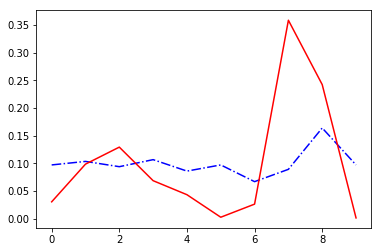

0.9109293579728336 2.279335525223793
0.11325344724723756 0.023587378032358705
[1, 151] generator loss: 0.013357845265418292 discriminator loss: 0.08057195633649826
--------------------


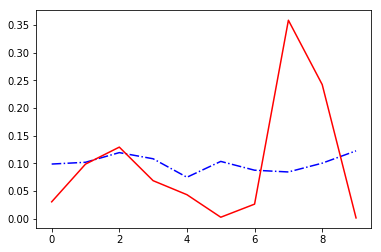

0.9422507024024946 2.310656869653454
0.11557828444785911 0.024309204810664307
[1, 301] generator loss: 0.013344531046847503 discriminator loss: 0.08057603061199188
--------------------


KeyboardInterrupt: 

In [55]:
dtype = torch.float32
torch.set_default_dtype(dtype)
temp_diff = 2.2
temp_net = 0
temp_dis = 0
for epoch in range(2000):
    running_loss = 0.
    dis_loss = 0.
    for i, data in enumerate(trainloader, 0):
        '''expert inputs , user info, and labels(actions)'''
        inputs, user, user_ID, labels = data
        inputs = inputs.float()
        user = user.float()
        user_ID = user_ID.float()
        labels = labels.long()
        
        batch_size = inputs.size(0)
        valid = Variable(FloatTensor(batch_size, 1).fill_(0.1), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(1.), requires_grad=False)
        
        fak_inputs, fak_user, fak_user_ID = random_sample_inputs2(expert_st, expert_ur, expert_u, batch_size)
        fak_inputs = fak_inputs.float()
        fak_user = fak_user.float()
        fak_user_ID = fak_user_ID.float()
        
        '''generate actions'''
        fak_labels = net.select_action(fak_inputs, fak_user, fak_user_ID)
        fak_prob = net.targeting_prob(fak_inputs, fak_user, fak_user_ID, fak_labels)
        
        '''getting scores'''
        exp_score = dis(inputs, user, user_ID, labels)
        fak_score = dis(fak_inputs, fak_user, fak_user_ID, fak_labels)

        
        '''updating net'''
        optimizer.zero_grad()
        loss = (criterion_dis(fak_score, valid)*fak_prob).mean()
        loss.backward()
        optimizer.step()
        
        '''updating dis'''
        optimizer_dis.zero_grad()
        fak_score = dis(fak_inputs, fak_user, fak_user_ID, fak_labels.detach())
        loss_dis = (criterion_dis(exp_score, valid).mean() + \
                    (criterion_dis(fak_score, fake)*fak_prob.detach()).mean())/2.

        loss_dis.backward()
        optimizer_dis.step()
                    
        
        running_loss += loss.item()
        dis_loss += loss_dis.item()
        if i % 150 == 0:
            print('[{}, {}] generator loss: {} discriminator loss: {}'.format((epoch+1), i+1, running_loss/150, dis_loss/150))
            print('--------------------')
            running_loss = 0.
            dis_loss = 0.
        
            if epoch % 5 == 0:
                out_loc = {}
                for i, data in enumerate(testloader, 0):
                    inputs, user, user_ID, labels = data
                    inputs = inputs.float()
                    user = user.float()
                    user_ID = user_ID.float()
                    labels = labels.long()
                    output = net.select_action(inputs, user, user_ID).tolist()

                    for i in range(inputs.size(0)):
                        x = int(inputs[i][0].item())
                        y = int(inputs[i][1].item())

                        if (x, y) not in out_loc:
                            out_loc[(x, y)] = np.zeros(10)
                            out_loc[(x, y)][output[i]] += 1
                        else:
                            out_loc[(x, y)][output[i]] += 1
                target = []
                ground = []
                for key in out_loc:
                    o1 = out_loc[key].copy()
                    o1 /= sum(o1)
                    if key in exp_loc:
                        o2 = np.zeros(10)
                        for b, w in exp_loc[key].items():
                            o2[b] += w
                        o2 /= sum(o2)
                        target.append(o1)
                        ground.append(o2)

                plt.figure()
                plt.plot(list(range(len(o1))), o1, color='blue', linestyle='dashdot')
                plt.plot(list(range(len(o2))), o2, color='red')
                plt.show()
                k, c, kls = cross_entropy(target, ground)
                print(k, c)
                diff = difference(target, ground)
                if c < temp_diff:
                    temp_diff = c
                    temp_net = deepcopy(net)
                    temp_dis = deepcopy(dis)